<h2><center>ROBOTIC PERCEPTION FINAL PROJECT</center></h2>

<center> Arunachalam Venkatachalam - 3330005000 </center>


Sensor fusion of IMU, GPS, and Lidar was implemented using an Extended Kalman Filter. The 3D Carla dataset originally in the form of ‘.pkl’ was converted to ‘.csv’ format by employing the data conversion script. Ground truth data, IMU data, GPS data, and Lidar data are stored and read separately. The ground-truth data consists of the timestamp, position, velocity, acceleration, rotation, rotational rate, and rotational acceleration values. The IMU consists of acceleration and gyroscope data. The Lidar data consists of X, Y, and Z position values. GPS data contains the Easting, Northing, and Up values.

<h3>Quaternion Class:</h3>

In [1]:
import numpy as np

def skew_symmetric(v):
    return np.array(
        [[0, -v[2], v[1]],
         [v[2], 0, -v[0]],
         [-v[1], v[0], 0]], dtype=np.float64)

class Quaternion():
    def __init__(self, w=1., x=0., y=0., z=0., axis_angle=None, euler=None):
        if axis_angle is None and euler is None:
            self.w = w
            self.x = x
            self.y = y
            self.z = z
        elif euler is not None and axis_angle is not None:
            raise AttributeError("Only one of axis_angle or euler can be specified.")
        elif axis_angle is not None:
            if not (type(axis_angle) == list or type(axis_angle) == np.ndarray) or len(axis_angle) != 3:
                raise ValueError("axis_angle must be list or np.ndarray with length 3.")
            axis_angle = np.array(axis_angle)
            norm = np.linalg.norm(axis_angle)
            self.w = np.cos(norm / 2)
            if norm < 1e-50:  # to avoid instabilities and nans
                self.x = 0
                self.y = 0
                self.z = 0
            else:
                imag = axis_angle / norm * np.sin(norm / 2)
                self.x = imag[0].item()
                self.y = imag[1].item()
                self.z = imag[2].item()
        else:
            roll = euler[0]
            pitch = euler[1]
            yaw = euler[2]

            cy = np.cos(yaw * 0.5)
            sy = np.sin(yaw * 0.5)
            cr = np.cos(roll * 0.5)
            sr = np.sin(roll * 0.5)
            cp = np.cos(pitch * 0.5)
            sp = np.sin(pitch * 0.5)

            self.w = cr * cp * cy + sr * sp * sy
            self.x = sr * cp * cy - cr * sp * sy
            self.y = cr * sp * cy + sr * cp * sy
            self.z = cr * cp * sy - sr * sp * cy

    def to_mat(self):
        v = np.array([self.x, self.y, self.z]).reshape(3,1)
        return (self.w ** 2 - np.dot(v.T, v)) * np.eye(3) + \
               2 * np.dot(v, v.T) + 2 * self.w * skew_symmetric(v)
    def to_euler(self):
        """Return as xyz (roll pitch yaw) Euler angles."""
        roll = np.arctan2(2 * (self.w * self.x + self.y * self.z), 1 - 2 * (self.x*2 + self.y*2))
        pitch = np.arcsin(2 * (self.w * self.y - self.z * self.x))
        yaw = np.arctan2(2 * (self.w * self.z + self.x * self.y), 1 - 2 * (self.y*2 + self.z*2))
        return np.array([roll,pitch,yaw])
    
    def to_numpy(self):
        return np.array([self.w, self.x, self.y, self.z])

    def quat_mult_right(self, q, out='np'):
        v = np.array([self.x, self.y, self.z]).reshape(3, 1)
        sum_term = np.zeros([4,4])
        sum_term[0,1:] = -v[:,0]
        sum_term[1:, 0] = v[:,0]
        sum_term[1:, 1:] = -skew_symmetric(v)
        sigma = self.w * np.eye(4) + sum_term

        if type(q).__name__ == "Quaternion":
            quat_np = np.dot(sigma, q.to_numpy())
        else:
            quat_np = np.dot(sigma, q)

        if out == 'np':
            return quat_np
        elif out == 'Quaternion':
            quat_obj = Quaternion(quat_np[0], quat_np[1], quat_np[2], quat_np[3])
            return quat_obj

<h3>Program</h3>

In [2]:
#Importing necessary libraries 
import numpy as np
from numpy import matmul
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

<h3>Reading data from excel file</h3>

In [3]:
"""
Col 0: Timestep, 
Col 1 : 4 - Position
Col 4 : 7 - Velocity
Col 7 : 10 - Acceleration
Col 10 : 13 - Euler Angles 
Col 13 : 16 - Rotational Rate
Col 16 : 19 - Rotational acceleration
"""
with open("GroundTruth_Data.csv") as file_name:
    gt = np.genfromtxt(file_name, delimiter=",")
gt[0,0]=2.055;

"""
Col 0: Timestep, 
Col 1 : 4 - Position
"""
with open("GPS_Data.csv") as file_name:
    gps = np.genfromtxt(file_name, delimiter=",")
gps[0,0]=2.055;

"""
Col 0: Timestep, 
Col 1 : 4 - Position
"""
with open("Lidar_Data.csv") as file_name:
    lidar = np.genfromtxt(file_name, delimiter=",")
lidar[0,0]=2.055;

"""
Col 0: Timestep, 
Col 1 : 4 - Acceleration
Col 4 : 7 - Gyro
"""
with open("IMU_Data.csv") as file_name:
    imu = np.genfromtxt(file_name, delimiter=",")
imu[0,0]=2.055;

<h3>The groundtruth values are plotted as a 3D graph</h3>

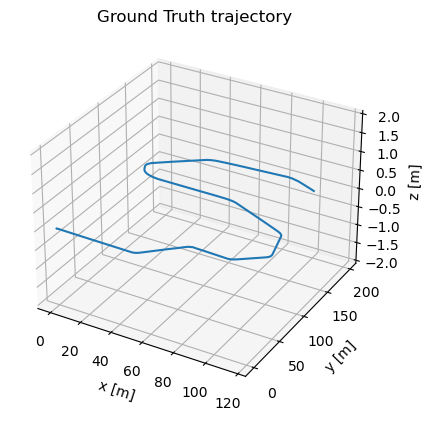

In [4]:
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(gt[:,1], gt[:,2], gt[:,3])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Ground Truth trajectory')
ax.set_zlim(-2, 2)
plt.show()

The LIDAR frame is not the same as the frame shared by the IMU and the GPS. So, we transform the LIDAR data to the IMU and GPS frame using extrinsic calibration rotation matrix C_li and translation vector t_i_li.

We assume the euler transformation is takes place in the ZYX order. This gives us the rotation matrix which would transform the Lidar values to the IMU+GPS frame.

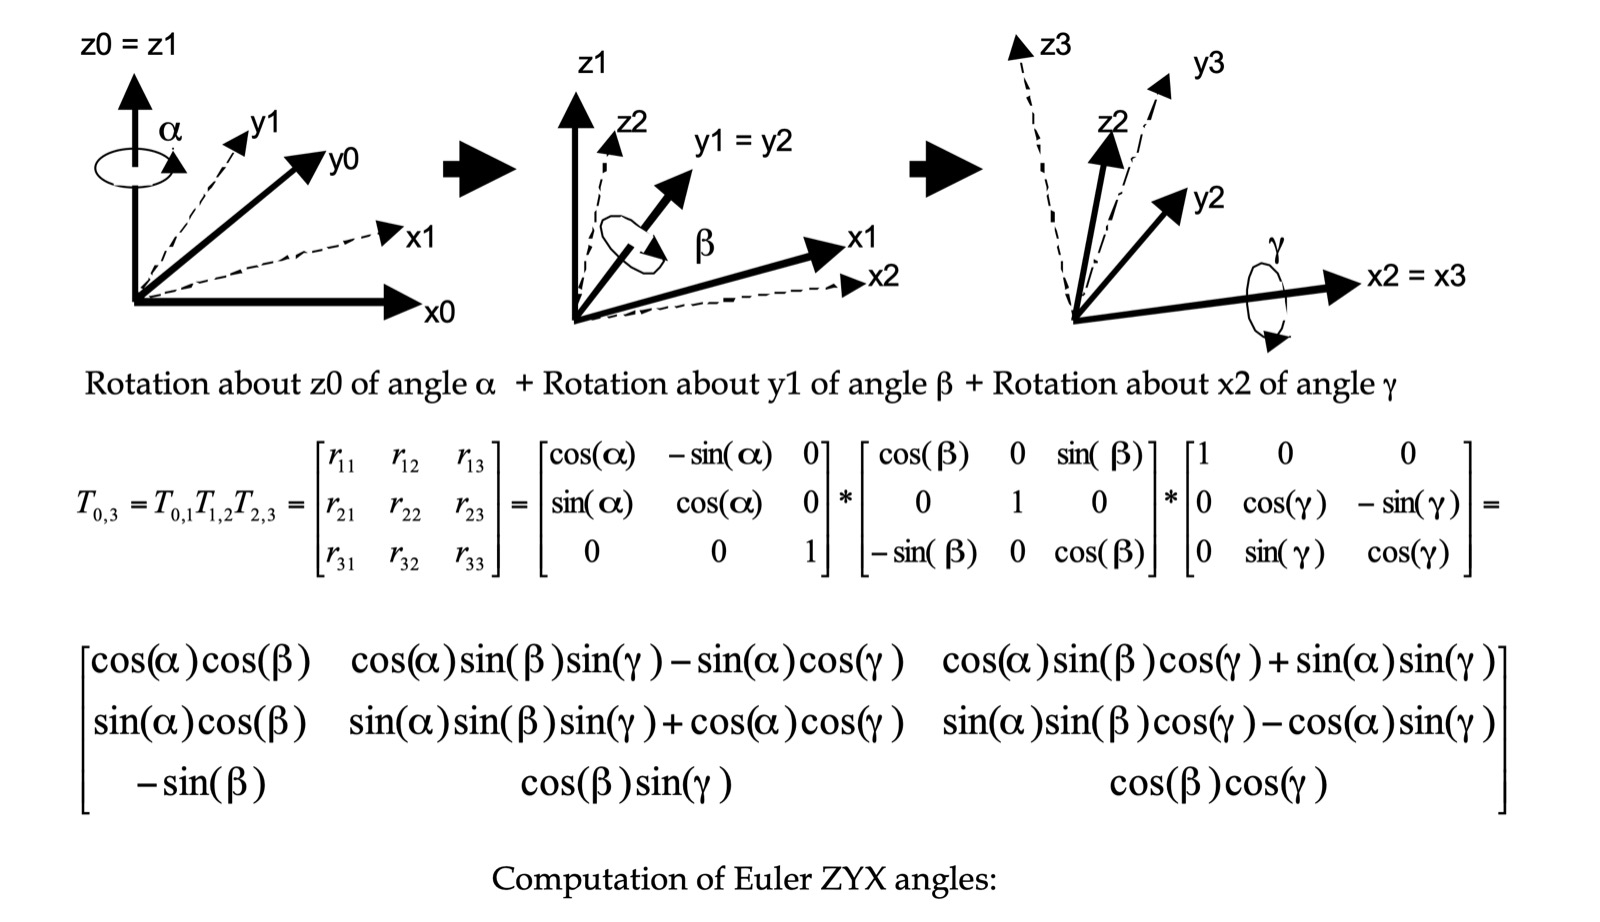

Computing correct calibration rotation matrix corresponding to Euler RPY angles ( gamma = 0.05, beta = 0.05, alpha = 0.1).

Since the Lidar is placed at a different location from the IMU+GPS combo, we need to translate the Lidar readings to the proper frame of reference to ensure all readings and estimates are computed with a single frame of reference. Thus, we calculate the translation matrix, which turns out to be (x = 0.5, y = 0.1, z = 0.5).

<h3>Transformations</h3>

In [5]:
C_li = np.array([
   [ 0.99376, -0.09722,  0.05466],
   [ 0.09971,  0.99401, -0.04475],
   [-0.04998,  0.04992,  0.9975 ]
])

t_i_li = np.array([0.5, 0.1, 0.5])
lidar[:,1:4] = (C_li @ lidar[:,1:4].T).T + t_i_li

Variance is computed by taking the difference between the groundtruth values and the respective X,Y,Z of GPS and Lidar. The variance of this difference would give me the respective variances in the X,Y and Z directions. Average of the three variances would provide the variance of that particular sensor.
When using an accelerometer or gyroscope, the variance is calculated by averaging Ax, Ay, and Az, subtracting the average from each value to obtain the difference, and then computing the mean of the squared difference to provide the variance matrix.

In [6]:
var_imu_f = 6
var_imu_w = 0.08
var_gps  = 6
var_lidar = 25

In [7]:
#Initializing the variables
g = np.array([0, 0, -9.81]) # gravity
Lj = np.zeros([15, 6])
Lj[3:6, 0:3] = np.eye(3)
Lj[6:9, 0:3] = np.eye(3)  # motion model noise jacobian
Lj[12:15, 3:6] = np.eye(3)  
Hj = np.zeros([3, 15])
Hj[:, :3] = np.eye(3)  # measurement model jacobian

#Initializing the matrix
ms=len(imu)
p = np.zeros([ms, 3])  # position estimates
v = np.zeros([ms, 3])  # velocity estimates
a = np.zeros([ms, 3])  # acceleration estimates
e = np.zeros([ms, 3])  #Euler angle
er= np.zeros([ms, 3])  #rate of change
q = np.zeros([ms, 4])  # orientation estimates as quaternions
x_state=np.zeros([15,ms]) #state variables
p_cov = np.zeros([ms, 15, 15])  # covariance matrices at each timestep

#Setting initial states to groundtruth
p[0] = gt[0,1:4]
v[0] = gt[0,4:7]
a[0] = gt[0,7:10]
e[0] = gt[0,10:13]
er[0] = gt[0,13:16]
q[0] = Quaternion(euler=gt[0,10:13]).to_numpy()
x_state[0:3,0]=p[0]
x_state[3:6,0]=v[0]
#x_state[6:9,0]=a[0]
#x_state[8,0]=x_state[8,0]-9.81
x_state[9:12,0]=e[0]
#x_state[12:15,0]=er[0]

p_cov[0] = np.zeros(15)  # covariance of estimate
gps_i  = 0
lidar_i = 0

The update rates of IMU, GPS and Lidar are different. Since IMU has a higher update rate than GPS and Lidar, we build the motion model using IMU. GPS and Lidar data are used in correction model.

In [8]:
def ekf(sensor_var, p_cov, y_k, x_state):
    # Compute Kalman Gain--> K_k = P_k * H_k.T * inv( H_k * P_k * H_k.T + R_k )
    quar=Quaternion(euler=x_state[9:12]).to_numpy()
    s = matmul(Hj, matmul(p_cov, Hj.T)) + sensor_var*np.eye(3)
    s[2,2]=s[2,2]*0.01
    s_i = np.linalg.inv(s)
    K = matmul(p_cov, matmul(Hj.T, s_i))
    
    # Compute error 
    e = y_k - matmul(Hj,x_state)

    # Correct predicted state
    p = x_state[0:3] + matmul(K, e)[:3]
    v = x_state[3:6] + matmul(K, e)[3:6]
    a = x_state[6:9] + matmul(K, e)[6:9]
    q_hat = Quaternion(axis_angle = matmul(K, e)[9:12]).quat_mult_right(quar)
    t=Quaternion(*q_hat).to_euler()
    e = t
    er = x_state[12:15] + matmul(K, e)[12:15]
     
    x_state_cor=np.zeros([15,1])
    x_state[0:3]=p
    x_state[3:6]=v
    x_state[6:9]=a
    x_state[9:12]=e
    x_state[12:15]=er

    # Compute corrected covariance
    p_cov_hat = matmul( np.eye(15) - matmul(K, Hj), p_cov)

    return x_state,p_cov_hat

In [ ]:
for k in range (1,ms):
    delt= imu[k,0] - imu [k-1,0]
    q[k-1]=Quaternion(euler=x_state[9:12,k-1]).to_numpy()
    cns = Quaternion(*q[k - 1]).to_mat()
    
    F = np.array([[1, 0, 0, delt, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, delt, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, delt, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, delt, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0, delt, 0, 0, 0, 0, 0, 0, 0],
                  [0 ,0, 0, 0, 0, 1, 0, 0, delt, 0, 0, 0, 0, 0, 0],
                  [0 ,0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0 ,0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0 ,0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0 ,0, 0, 0, 0, 0, 0, 1, 0, 0, delt, 0, 0],
                  [0, 0, 0, 0 ,0, 0, 0, 0, 0, 0, 1, 0, 0, delt, 0],
                  [0, 0, 0, 0, 0 ,0, 0, 0, 0, 0, 0, 1, 0, 0, delt],
                  [0, 0, 0 ,0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0 ,0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0 ,0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
    
    temp=(matmul(cns,imu[k-1,1:4]) + g)*(delt**2) * 0.5
    F[0,6]=temp[0]
    F[1,7]=temp[1]
    F[2,8]=temp[2]
    
    
    # Propagate uncertainty
    Q = np.eye(6)
    Q[0:3, 0:3] = var_imu_f * Q[0:3, 0:3]
    Q[3:6, 3:6] = var_imu_w * Q[3:6, 3:6]
    Q = Q*(delt**2)
    
    x_state[:,k]=matmul(F,x_state[:,k-1])
    
    p_cov[k] = matmul(F, matmul(p_cov[k - 1], F.T)) + matmul(Lj, matmul(Q, Lj.T))
    
    # Check availability of GPS and LIDAR measurements
    
    for i in range(len(gps)):
        if abs(gps[i,0] - imu[k,0]) < 0.01:
            x_state[:,k], p_cov[k] = ekf(var_gps, p_cov[k], gps[i,1:4], x_state[:,k])           
    
    
    for i in range(len(lidar)):
        if abs(lidar[i,0] - imu[k,0]) < 0.01:
            x_state[:,k], p_cov[k] = ekf(var_lidar, p_cov[k], lidar[i,1:4], x_state[:,k])
    

<h3>With both Lidar and GPS</h3>

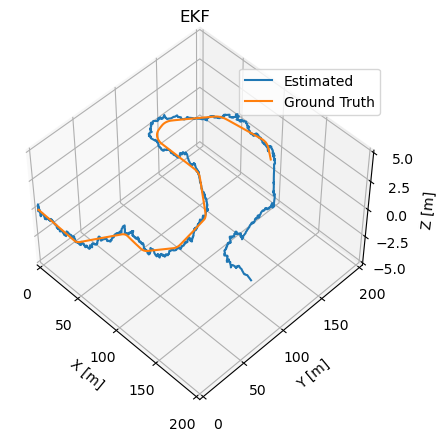

In [10]:
est_traj_fig = plt.figure()
ax = est_traj_fig.add_subplot(111, projection='3d')
ax.plot(x_state[0,:], x_state[1,:], x_state[2,:], label='Estimated')
ax.plot(gt[:,1], gt[:,2], gt[:,3], label='Ground Truth')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title('EKF')
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.set_zlim(-2, 2)
ax.set_xticks([0, 50, 100, 150, 200])
ax.set_yticks([0, 50, 100, 150, 200])
ax.set_zticks([-5, -2.5, 0, 2.5, 5])
ax.legend(loc=(0.62,0.77))
ax.view_init(elev=50, azim=-45)
plt.show()

<h3>With only Lidar</h3>

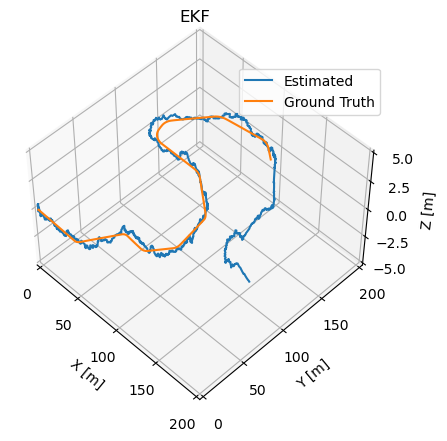

In [10]:
est_traj_fig = plt.figure()
ax = est_traj_fig.add_subplot(111, projection='3d')
ax.plot(x_state[0,:], x_state[1,:], x_state[2,:], label='Estimated')
ax.plot(gt[:,1], gt[:,2], gt[:,3], label='Ground Truth')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title('EKF')
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.set_zlim(-2, 2)
ax.set_xticks([0, 50, 100, 150, 200])
ax.set_yticks([0, 50, 100, 150, 200])
ax.set_zticks([-5, -2.5, 0, 2.5, 5])
ax.legend(loc=(0.62,0.77))
ax.view_init(elev=50, azim=-45)
plt.show()

<h3>Error Graphs(With Lidar and Gps)</h3>

In [13]:
n=len(gt[:,1:4])
er1=np.zeros((n,3))
for i in range(n):
    er1[i,:]=(gt[i,1:4]-x_state[0:3,i])

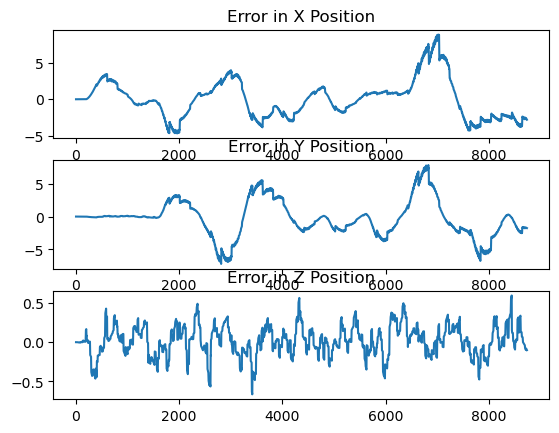

In [14]:
#plot 1:
x = np.arange(1,n+1)
y = er1[:,0]

plt.subplot(3, 1, 1)
plt.plot(x,y)
plt.title("Error in X Position")

#plot 2:
x = np.arange(1,n+1)
y = er1[:,1]

plt.subplot(3, 1, 2)
plt.plot(x,y)
plt.title("Error in Y Position")

#plot 3:
x = np.arange(1,n+1)
y = er1[:,2]

plt.subplot(3, 1, 3)
plt.plot(x,y)
plt.title("Error in Z Position")

plt.show()

<h3>Error Graphs(With Lidar)</h3>

In [11]:
n=len(gt[:,1:4])
er2=np.zeros((n,3))
for i in range(n):
    er2[i,:]=(gt[i,1:4]-x_state[0:3,i])

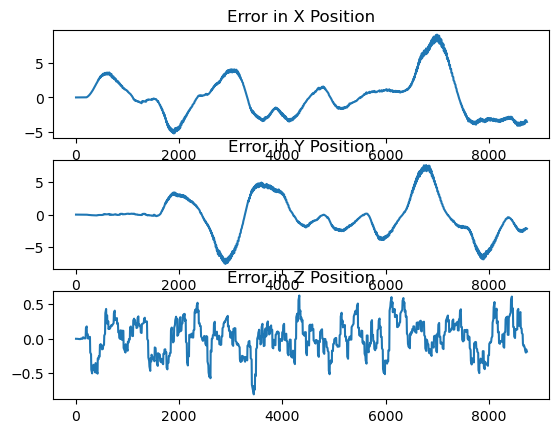

In [12]:
#plot 1:
x = np.arange(1,n+1)
y = er2[:,0]

plt.subplot(3, 1, 1)
plt.plot(x,y)
plt.title("Error in X Position")

#plot 2:
x = np.arange(1,n+1)
y = er2[:,1]

plt.subplot(3, 1, 2)
plt.plot(x,y)
plt.title("Error in Y Position")

#plot 3:
x = np.arange(1,n+1)
y = er2[:,2]

plt.subplot(3, 1, 3)
plt.plot(x,y)
plt.title("Error in Z Position")

plt.show()

<h3>RMS error for IMU+GPS+Lidar</h3>

In [15]:
a1=np.sqrt(np.mean((er1[:,0])**2))
a2=np.sqrt(np.mean((er1[:,1])**2))
a3=np.sqrt(np.mean((er1[:,2])**2))
print(a1,a2,a3)

2.6080947952286606 2.7701408615288927 0.18968378884117887


<h3>RMS error for IMU+Lidar without GPS</h3>

In [13]:
c1=np.sqrt(np.mean((er2[:,0])**2))
c2=np.sqrt(np.mean((er2[:,1])**2))
c3=np.sqrt(np.mean((er2[:,2])**2))
print(c1,c2,c3)

2.922282149523162 2.986319409619482 0.23510723402290812


The RMS error and error plots show that including GPS along with Lidar and IMU reduces the error.